In [12]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {device}")

Dispositivo: cuda


In [13]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
model = model.to(device)
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [14]:
# Função auxiliar para preprocessar texto e garantir que não ultrapasse o limite
def preprocessar_texto_questao(texto_completo, max_length=77):
    """
    Preprocessa o texto da questão para caber no limite do CLIP.
    Remove alternativas de múltipla escolha e mantém apenas o enunciado principal.
    
    O CLIP tem um limite fixo de 77 tokens. Em vez de apenas truncar o texto,
    vamos extrair a parte mais relevante que é o enunciado da questão, removendo
    as alternativas que geralmente começam com letras seguidas de parênteses.
    
    Args:
        texto_completo: Texto completo da questão com alternativas
        max_length: Limite de tokens (padrão 77 para CLIP)
        
    Returns:
        String com apenas o enunciado principal da questão
    """
    # Remover espaços extras e quebras de linha
    texto = texto_completo.strip()
    texto = re.sub(r'\s+', ' ', texto)
    
    # Tentar identificar onde começam as alternativas
    # Padrões comuns: "a)", "a )", "A)", etc.
    padrao_alternativas = r'\n?\s*[a-eA-E]\s*\)'
    
    # Encontrar a primeira ocorrência de alternativa
    match = re.search(padrao_alternativas, texto)
    
    if match:
        # Pegar apenas o texto antes das alternativas
        texto_enunciado = texto[:match.start()].strip()
    else:
        # Se não encontrar alternativas, usar o texto todo
        texto_enunciado = texto
    
    # Agora vamos verificar quantos tokens esse texto tem
    # e truncar se necessário, mas de forma inteligente
    tokens = processor.tokenizer.encode(texto_enunciado, add_special_tokens=False)
    
    if len(tokens) > max_length - 2:  # -2 para os tokens especiais [CLS] e [SEP]
        # Se ainda está muito longo, truncar mantendo o início
        # O início geralmente contém a informação mais importante
        tokens_truncados = tokens[:max_length - 2]
        texto_final = processor.tokenizer.decode(tokens_truncados)
        print(f"⚠ Texto truncado de {len(tokens)} para {len(tokens_truncados)} tokens")
    else:
        texto_final = texto_enunciado
    
    return texto_final

In [18]:
questoes_raw = {
    "garfield": {
        "imagem": "garfield.png",
        "texto": """
        A tira, definida como um segmento de história em quadrinhos, pode transmitir 
        uma mensagem com efeito de humor. A presença desse efeito no diálogo entre 
        Jon e Garfield acontece porque?
        """,
        "descricao": "Tirinha Garfield (linguística/interpretação)"
    },
    
    "mafalda": {
        "imagem": "boy.png", 
        "texto": """
        Nessa charge, o recurso morfossintático que colabora para o efeito de humor está
        indicado pelo emprego de uma oração adversativa, que orienta a quebra da expectativa
        ao final, uso de conjunção aditiva, retomada do substantivo mãe, ou utilização da
        forma pronominal la.
        """,
        "descricao": "Charge Mafalda (linguística/gramática)"
    },
    
    "heredograma": {
        "imagem": "heredograma.png",
        "texto": """
        No heredograma, os símbolos preenchidos representam pessoas portadoras de um tipo
        raro de doença genética. Os homens são representados pelos quadrados e as
        mulheres, pelos círculos. Qual é o padrão de herança observado para essa doença?
        a) Dominante autossômico, pois a doença aparece em ambos os sexos.
        b) Recessivo ligado ao sexo, pois não ocorre a transmissão do pai para os filhos.
        c) Recessivo ligado ao Y, pois a doença é transmitida dos pais heterozigotos para os filhos.
        d) Dominante ligado ao sexo, pois todas as filhas de homens afetados também apresentam a doença.
        e) Codominante autossômico, pois a doença é herdada pelos filhos de ambos os sexos, tanto do pai quanto da mãe.
        """,
        "descricao": "Heredograma (biologia/genética)"
    },
    
    "circuito": {
        "imagem": "circuito.png",
        "texto": """
        Fusível é um dispositivo de proteção contra sobrecorrente em circuitos.
        Quando a corrente que passa por esse componente elétrico é maior que sua máxima
        corrente nominal, o fusível queima. Dessa forma, evita que a corrente elevada danifique
        os aparelhos do circuito. Supondo que o circuito elétrico mostrado seja alimentado por
        uma fonte de tensão U e que o fusível suporte uma corrente nominal de 500 mA,
        qual é o máximo valor da tensão U para que o fusível não queime?
        a) 20 V
        b) 40 V
        c) 60 V
        d) 120 V
        e) 185 V
        """,
        "descricao": "Circuito elétrico (física)"
    },
    
    "mapa": {
        "imagem": "mapa.png",
        "texto": """
        Dentro das atuais redes produtivas, o referido bloco apresenta composição estratégica
        por se tratar de um conjunto de países com elevado padrão social, sistema monetário
        integrado, alto desenvolvimento tecnológico, identidades culturais semelhantes, ou
        vantagens locacionais complementares.
        a) elevado padrão social.
        b) sistema monetário integrado.
        c) alto desenvolvimento tecnológico.
        d) identidades culturais semelhantes.
        e) vantagens locacionais complementares.
        """,
        "descricao": "Mapa-múndi (geografia/geopolítica)"
    }
}

In [19]:
questoes = {}
for key, info in questoes_raw.items():
    texto_processado = preprocessar_texto_questao(info['texto'])
    questoes[key] = {
        'imagem': info['imagem'],
        'texto': texto_processado,
        'descricao': info['descricao']
    }
    
    # Mostrar o texto processado para cada questão
    print(f"{info['descricao']}:")
    print(f"  Texto processado: {texto_processado[:100]}...")
    num_tokens = len(processor.tokenizer.encode(texto_processado))
    print(f"  Número de tokens: {num_tokens}/77")
    print()


Tirinha Garfield (linguística/interpretação):
  Texto processado: A tira, definida como um segmento de história em quadrinhos, pode transmitir uma mensagem com efeito...
  Número de tokens: 60/77

⚠ Texto truncado de 87 para 75 tokens
Charge Mafalda (linguística/gramática):
  Texto processado: nessa charge , o recurso morfossintático que colabora para o efeito de humor está indicado pelo empr...
  Número de tokens: 77/77

⚠ Texto truncado de 80 para 75 tokens
Heredograma (biologia/genética):
  Texto processado: no heredograma , os símbolos preenchidos representam pessoas portadoras de um tipo raro de doença ge...
  Número de tokens: 77/77

⚠ Texto truncado de 159 para 75 tokens
Circuito elétrico (física):
  Texto processado: fusível é um dispositivo de proteção contra sobrecorrente em circuitos . quando a corrente que passa...
  Número de tokens: 78/77

⚠ Texto truncado de 95 para 75 tokens
Mapa-múndi (geografia/geopolítica):
  Texto processado: dentro das atuais redes produtivas , o r

In [21]:
def calcular_similaridade(imagem_path, texto):
    """
    Calcula a similaridade cosseno entre uma imagem e um texto usando CLIP.
    
    O CLIP funciona mapeando tanto imagens quanto textos para o mesmo espaço
    vetorial de embeddings. Quando uma imagem e um texto estão semanticamente
    relacionados, seus embeddings ficam próximos nesse espaço. A similaridade
    cosseno mede exatamente essa proximidade através do ângulo entre os vetores.
    
    Args:
        imagem_path: Caminho para o arquivo de imagem
        texto: String contendo o texto da questão (já preprocessado)
        
    Returns:
        float: Similaridade cosseno entre -1 e 1
    """
    # Carregar e processar a imagem
    imagem = Image.open(imagem_path).convert('RGB')
    image_inputs = processor(images=imagem, return_tensors="pt").to(device)
    
    # Processar o texto com truncation explícito para segurança
    text_inputs = processor(
        text=texto, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=77
    ).to(device)
    
    # Extrair features e calcular similaridade
    with torch.no_grad():
        image_features = model.get_image_features(**image_inputs)
        text_features = model.get_text_features(**text_inputs)
        
        # Normalizar os vetores para cálculo de similaridade cosseno
        # A normalização garante que estamos medindo apenas o ângulo,
        # não a magnitude dos vetores
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Calcular similaridade cosseno (produto escalar de vetores normalizados)
        similarity = (image_features @ text_features.T).item()
    
    return similarity

In [22]:
resultados = {
    'corretos': [],      # Pares onde texto e imagem correspondem
    'incorretos': [],    # Pares onde não correspondem
    'detalhes': []       # Lista com todos os detalhes de cada teste
}

# Para cada questão (que serve como fonte da imagem)
for key_imagem, info_imagem in questoes.items():
    print(f"Testando imagem: {info_imagem['descricao']}")
    print("-" * 80)
    
    # Testar essa imagem com o texto de cada questão
    for key_texto, info_texto in questoes.items():
        # Calcular similaridade
        sim = calcular_similaridade(info_imagem['imagem'], info_texto['texto'])
        
        # Determinar se este é um par correto ou incorreto
        eh_par_correto = (key_imagem == key_texto)
        
        # Armazenar o resultado
        resultado = {
            'imagem': info_imagem['descricao'],
            'texto': info_texto['descricao'],
            'similaridade': sim,
            'correto': eh_par_correto
        }
        resultados['detalhes'].append(resultado)
        
        # Adicionar à lista apropriada
        if eh_par_correto:
            resultados['corretos'].append(sim)
        else:
            resultados['incorretos'].append(sim)
        
        # Mostrar o resultado com formatação clara
        simbolo = "✓" if eh_par_correto else "✗"
        tipo = "CORRETO  " if eh_par_correto else "INCORRETO"
        print(f"  {simbolo} [{tipo}] com texto: {info_texto['descricao']:<40} → {sim:.4f}")
    
    print()

Testando imagem: Tirinha Garfield (linguística/interpretação)
--------------------------------------------------------------------------------
  ✓ [CORRETO  ] com texto: Tirinha Garfield (linguística/interpretação) → 0.3072
  ✗ [INCORRETO] com texto: Charge Mafalda (linguística/gramática)   → 0.2315
  ✗ [INCORRETO] com texto: Heredograma (biologia/genética)          → 0.2150
  ✗ [INCORRETO] com texto: Circuito elétrico (física)               → 0.2076
  ✗ [INCORRETO] com texto: Mapa-múndi (geografia/geopolítica)       → 0.1851

Testando imagem: Charge Mafalda (linguística/gramática)
--------------------------------------------------------------------------------
  ✗ [INCORRETO] com texto: Tirinha Garfield (linguística/interpretação) → 0.3216
  ✓ [CORRETO  ] com texto: Charge Mafalda (linguística/gramática)   → 0.2890
  ✗ [INCORRETO] com texto: Heredograma (biologia/genética)          → 0.2632
  ✗ [INCORRETO] com texto: Circuito elétrico (física)               → 0.2495
  ✗ [INCORRETO] co

ESTATÍSTICAS DAS SIMILARIDADES

PARES CORRETOS (texto corresponde à imagem):
  Quantidade: 5
  Média: 0.2627
  Desvio padrão: 0.0332
  Mínimo: 0.2167
  Máximo: 0.3072

PARES INCORRETOS (texto NÃO corresponde à imagem):
  Quantidade: 20
  Média: 0.2194
  Desvio padrão: 0.0319
  Mínimo: 0.1819
  Máximo: 0.3216

Diferença entre médias: 0.0433

ANÁLISE DO THRESHOLD IDEAL

Menor similaridade em par CORRETO: 0.2167
Maior similaridade em par INCORRETO: 0.3216
Gap entre eles: -0.1049

THRESHOLD SUGERIDO: 0.2691

Interpretação:
  ⚠ ATENÇÃO: Há sobreposição entre pares corretos e incorretos!
  Isso indica que algumas combinações são ambíguas para o modelo.
  Usando threshold de 0.2691 mesmo assim.

TESTANDO EFICÁCIA DO THRESHOLD SUGERIDO

Verdadeiros Positivos (acertou que corresponde): 2/5
Falsos Negativos (errou dizendo que não corresponde): 3/5
Verdadeiros Negativos (acertou que não corresponde): 19/20
Falsos Positivos (errou dizendo que corresponde): 1/20

Acurácia: 84.00%
Precisão: 66.67%
R

/tmp/ipykernel_248158/2936005097.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_for_boxplot, labels=['Corretos', 'Incorretos'], patch_artist=True)


✓ Gráfico salvo como 'safelearn_calibracao.png'

Salvando resultados detalhados...
✓ Resultados salvos em 'safelearn_resultados_calibracao.txt'

CALIBRAÇÃO CONCLUÍDA!

Próximos passos:
1. Analise o gráfico 'safelearn_calibracao.png' para visualizar os resultados
2. Revise o arquivo 'safelearn_resultados_calibracao.txt' para detalhes completos
3. Use o threshold de 0.2691 no sistema de verificação final
4. Inclua essas análises no relatório do trabalho



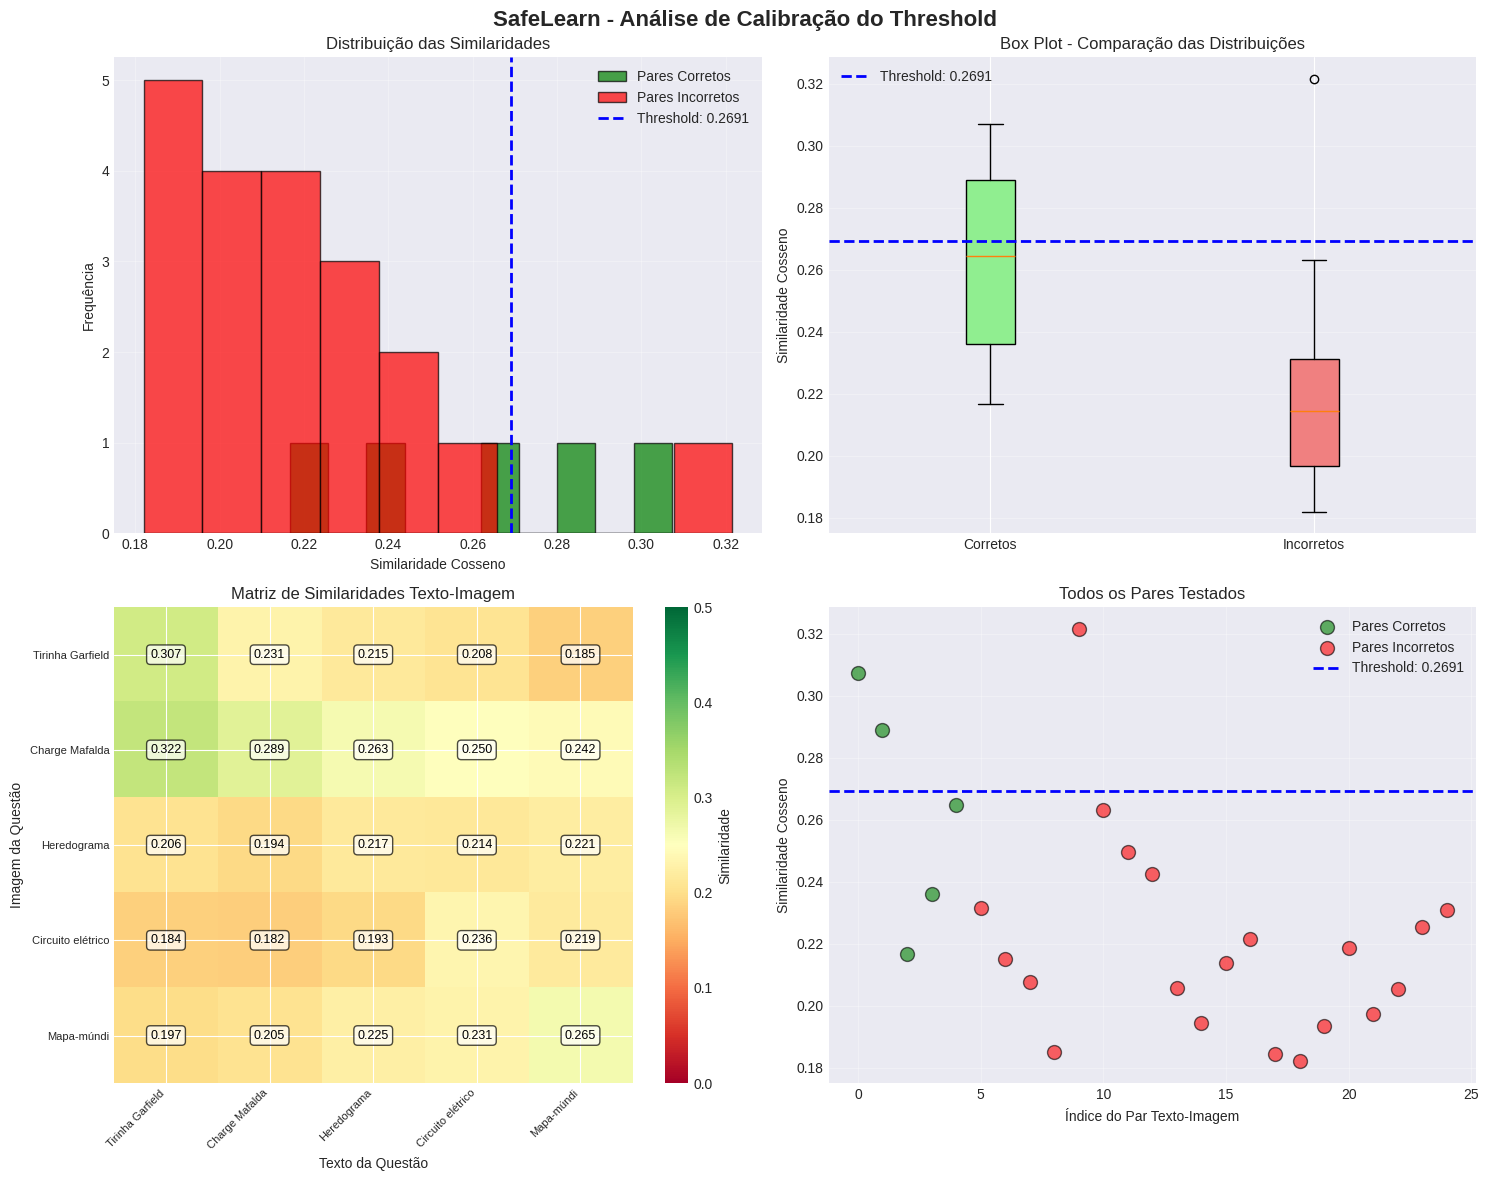

In [23]:
print("="*80)
print("ESTATÍSTICAS DAS SIMILARIDADES")
print("="*80)
print()

print("PARES CORRETOS (texto corresponde à imagem):")
print(f"  Quantidade: {len(resultados['corretos'])}")
print(f"  Média: {np.mean(resultados['corretos']):.4f}")
print(f"  Desvio padrão: {np.std(resultados['corretos']):.4f}")
print(f"  Mínimo: {np.min(resultados['corretos']):.4f}")
print(f"  Máximo: {np.max(resultados['corretos']):.4f}")
print()

print("PARES INCORRETOS (texto NÃO corresponde à imagem):")
print(f"  Quantidade: {len(resultados['incorretos'])}")
print(f"  Média: {np.mean(resultados['incorretos']):.4f}")
print(f"  Desvio padrão: {np.std(resultados['incorretos']):.4f}")
print(f"  Mínimo: {np.min(resultados['incorretos']):.4f}")
print(f"  Máximo: {np.max(resultados['incorretos']):.4f}")
print()

# Calcular a diferença entre as médias
diferenca_medias = np.mean(resultados['corretos']) - np.mean(resultados['incorretos'])
print(f"Diferença entre médias: {diferenca_medias:.4f}")
print()

# Sugerir um threshold baseado nos dados
min_correto = np.min(resultados['corretos'])
max_incorreto = np.max(resultados['incorretos'])
threshold_sugerido = (min_correto + max_incorreto) / 2

print("="*80)
print("ANÁLISE DO THRESHOLD IDEAL")
print("="*80)
print()
print(f"Menor similaridade em par CORRETO: {min_correto:.4f}")
print(f"Maior similaridade em par INCORRETO: {max_incorreto:.4f}")
print(f"Gap entre eles: {min_correto - max_incorreto:.4f}")
print()
print(f"THRESHOLD SUGERIDO: {threshold_sugerido:.4f}")
print()
print("Interpretação:")
if min_correto > max_incorreto:
    print(f"  ✓ Existe separação clara entre pares corretos e incorretos!")
    print(f"  • Similaridade ≥ {threshold_sugerido:.4f} → Imagem CORRESPONDE ao texto")
    print(f"  • Similaridade < {threshold_sugerido:.4f} → Imagem NÃO CORRESPONDE ao texto")
else:
    print("  ⚠ ATENÇÃO: Há sobreposição entre pares corretos e incorretos!")
    print("  Isso indica que algumas combinações são ambíguas para o modelo.")
    print(f"  Usando threshold de {threshold_sugerido:.4f} mesmo assim.")
print()

# Testar a eficácia do threshold sugerido
print("="*80)
print("TESTANDO EFICÁCIA DO THRESHOLD SUGERIDO")
print("="*80)
print()

true_positives = sum(1 for s in resultados['corretos'] if s >= threshold_sugerido)
false_negatives = sum(1 for s in resultados['corretos'] if s < threshold_sugerido)
true_negatives = sum(1 for s in resultados['incorretos'] if s < threshold_sugerido)
false_positives = sum(1 for s in resultados['incorretos'] if s >= threshold_sugerido)

total = len(resultados['corretos']) + len(resultados['incorretos'])
acuracia = (true_positives + true_negatives) / total
precisao = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precisao * recall) / (precisao + recall) if (precisao + recall) > 0 else 0

print(f"Verdadeiros Positivos (acertou que corresponde): {true_positives}/{len(resultados['corretos'])}")
print(f"Falsos Negativos (errou dizendo que não corresponde): {false_negatives}/{len(resultados['corretos'])}")
print(f"Verdadeiros Negativos (acertou que não corresponde): {true_negatives}/{len(resultados['incorretos'])}")
print(f"Falsos Positivos (errou dizendo que corresponde): {false_positives}/{len(resultados['incorretos'])}")
print()
print(f"Acurácia: {acuracia*100:.2f}%")
print(f"Precisão: {precisao*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1_score:.4f}")
print()

# Criar visualizações
print("="*80)
print("GERANDO VISUALIZAÇÕES")
print("="*80)
print()

# Configurar o estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('SafeLearn - Análise de Calibração do Threshold', fontsize=16, fontweight='bold')

# Gráfico 1: Histograma das similaridades
ax1 = axes[0, 0]
ax1.hist(resultados['corretos'], bins=10, alpha=0.7, label='Pares Corretos', color='green', edgecolor='black')
ax1.hist(resultados['incorretos'], bins=10, alpha=0.7, label='Pares Incorretos', color='red', edgecolor='black')
ax1.axvline(threshold_sugerido, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {threshold_sugerido:.4f}')
ax1.set_xlabel('Similaridade Cosseno')
ax1.set_ylabel('Frequência')
ax1.set_title('Distribuição das Similaridades')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Box plot comparativo
ax2 = axes[0, 1]
data_for_boxplot = [resultados['corretos'], resultados['incorretos']]
bp = ax2.boxplot(data_for_boxplot, labels=['Corretos', 'Incorretos'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.axhline(threshold_sugerido, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {threshold_sugerido:.4f}')
ax2.set_ylabel('Similaridade Cosseno')
ax2.set_title('Box Plot - Comparação das Distribuições')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Gráfico 3: Matriz de similaridades
ax3 = axes[1, 0]
labels_questoes = [info['descricao'].split('(')[0].strip() for info in questoes.values()]
matriz_sim = np.zeros((len(questoes), len(questoes)))

for i, key_img in enumerate(questoes.keys()):
    for j, key_txt in enumerate(questoes.keys()):
        for detalhe in resultados['detalhes']:
            if (questoes[key_img]['descricao'] == detalhe['imagem'] and 
                questoes[key_txt]['descricao'] == detalhe['texto']):
                matriz_sim[i][j] = detalhe['similaridade']
                break

im = ax3.imshow(matriz_sim, cmap='RdYlGn', aspect='auto', vmin=0, vmax=0.5)
ax3.set_xticks(range(len(labels_questoes)))
ax3.set_yticks(range(len(labels_questoes)))
ax3.set_xticklabels(labels_questoes, rotation=45, ha='right', fontsize=8)
ax3.set_yticklabels(labels_questoes, fontsize=8)
ax3.set_xlabel('Texto da Questão')
ax3.set_ylabel('Imagem da Questão')
ax3.set_title('Matriz de Similaridades Texto-Imagem')

for i in range(len(labels_questoes)):
    for j in range(len(labels_questoes)):
        text = ax3.text(j, i, f'{matriz_sim[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.colorbar(im, ax=ax3, label='Similaridade')

# Gráfico 4: Scatter plot de todos os pares
ax4 = axes[1, 1]
corretos_x = list(range(len(resultados['corretos'])))
incorretos_x = list(range(len(resultados['corretos']), len(resultados['corretos']) + len(resultados['incorretos'])))

ax4.scatter(corretos_x, resultados['corretos'], c='green', s=100, alpha=0.6, label='Pares Corretos', edgecolors='black')
ax4.scatter(incorretos_x, resultados['incorretos'], c='red', s=100, alpha=0.6, label='Pares Incorretos', edgecolors='black')
ax4.axhline(threshold_sugerido, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {threshold_sugerido:.4f}')
ax4.set_xlabel('Índice do Par Texto-Imagem')
ax4.set_ylabel('Similaridade Cosseno')
ax4.set_title('Todos os Pares Testados')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('safelearn_calibracao.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo como 'safelearn_calibracao.png'")
print()

# Salvar resultados detalhados
print("Salvando resultados detalhados...")
with open('safelearn_resultados_calibracao.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("SAFELEARN - RESULTADOS DETALHADOS DA CALIBRAÇÃO\n")
    f.write("="*80 + "\n\n")
    
    f.write("CONFIGURAÇÃO:\n")
    f.write(f"Modelo: {model_name}\n")
    f.write(f"Dispositivo: {device}\n")
    f.write(f"Threshold sugerido: {threshold_sugerido:.4f}\n\n")
    
    f.write("MÉTRICAS DE DESEMPENHO:\n")
    f.write(f"Acurácia: {acuracia*100:.2f}%\n")
    f.write(f"Precisão: {precisao*100:.2f}%\n")
    f.write(f"Recall: {recall*100:.2f}%\n")
    f.write(f"F1-Score: {f1_score:.4f}\n\n")
    
    f.write("TODOS OS PARES TESTADOS:\n")
    f.write("-"*80 + "\n")
    for detalhe in resultados['detalhes']:
        tipo = "CORRETO" if detalhe['correto'] else "INCORRETO"
        f.write(f"\n[{tipo}]\n")
        f.write(f"Imagem: {detalhe['imagem']}\n")
        f.write(f"Texto: {detalhe['texto']}\n")
        f.write(f"Similaridade: {detalhe['similaridade']:.4f}\n")
        classificacao = "CORRESPONDE" if detalhe['similaridade'] >= threshold_sugerido else "NÃO CORRESPONDE"
        f.write(f"Classificação com threshold: {classificacao}\n")

print("✓ Resultados salvos em 'safelearn_resultados_calibracao.txt'")
print()

print("="*80)
print("CALIBRAÇÃO CONCLUÍDA!")
print("="*80)
print()
print("Próximos passos:")
print("1. Analise o gráfico 'safelearn_calibracao.png' para visualizar os resultados")
print("2. Revise o arquivo 'safelearn_resultados_calibracao.txt' para detalhes completos")
print(f"3. Use o threshold de {threshold_sugerido:.4f} no sistema de verificação final")
print("4. Inclua essas análises no relatório do trabalho")
print()